In [1]:
pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 11.1 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

### Reimporting dataframes and setting indices.

In [2]:
transformed_path = '/Users/markos98/aquasteady_research/data/transformed/'
features23 = pd.read_csv(transformed_path + 'features23.csv')
features23 = features23.set_index('AREA')

In [18]:
regions = pd.read_csv(transformed_path + 'regions23.csv')
regions = regions.set_index('IMPEDIMENT')

### Correlation matrix shows that variables are overfitted.

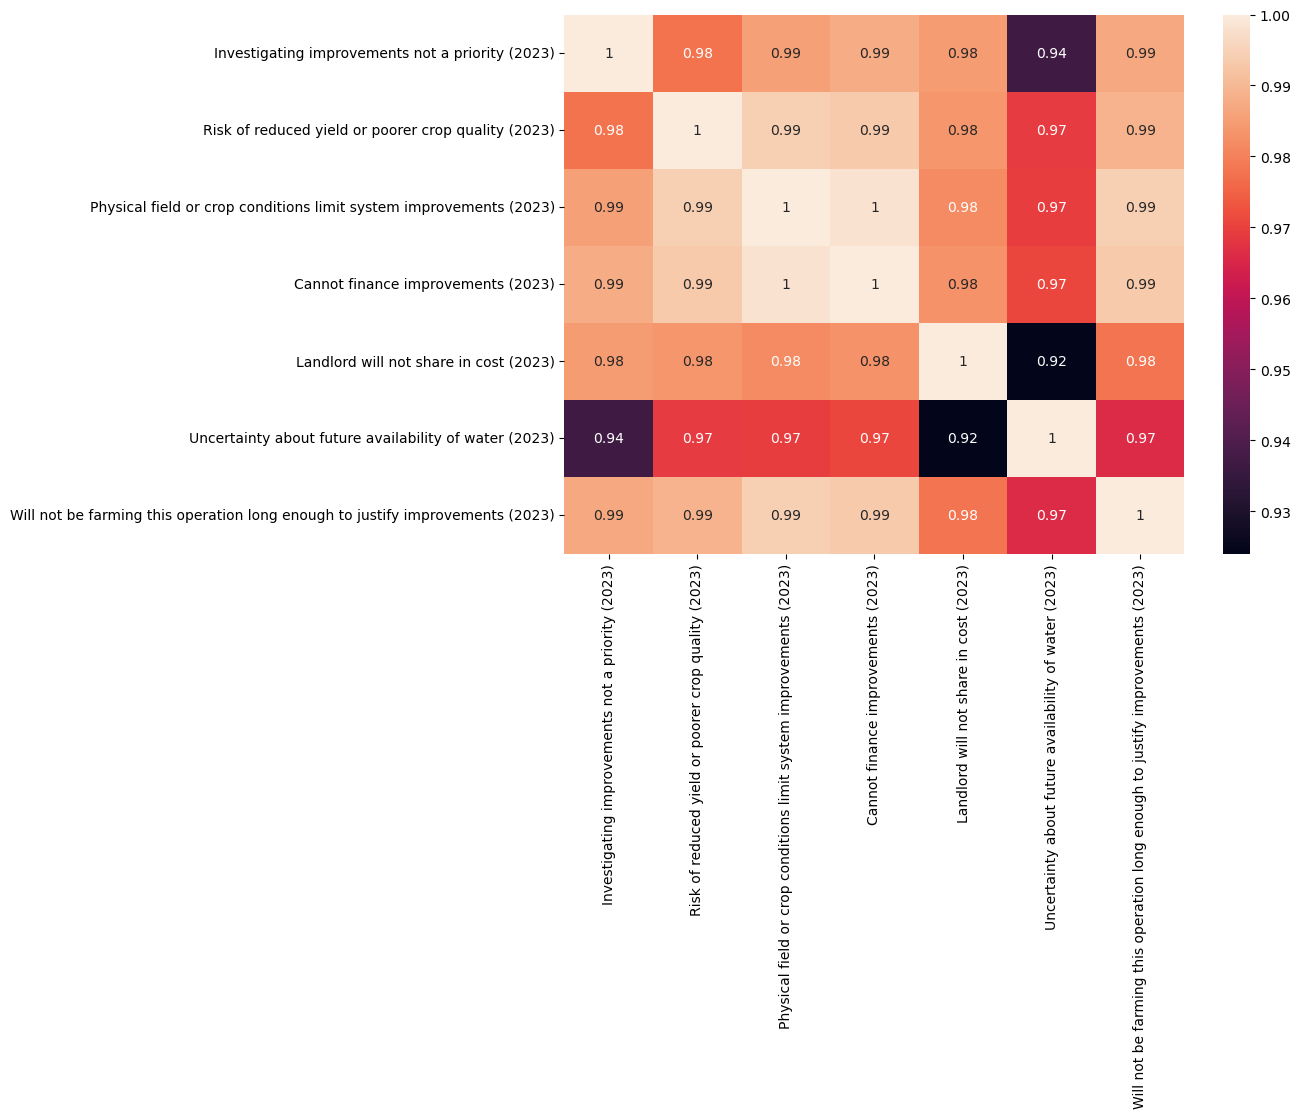

In [7]:
corr_matrix = features23.corr()
fig, ax = plt.subplots(figsize=(10, 7))
sb.heatmap(corr_matrix, annot=True, ax=ax)
plt.show()

# Using Random Forest Classifier for feature selection on regions first. Going to cull whatever places seem to be creating noise.

In [19]:
le = LabelEncoder()

y = regions.index.values  # Get the index values as target
X = regions.copy()  # Features are the remaining columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = RandomForestClassifier(random_state=1, max_depth=12)
model.fit(X_train, y_train)
display(model.feature_importances_)
fl = pd.get_dummies(X)
features = fl.columns
importances = model.feature_importances_
indices = np.argsort(importances)[:]

array([0.01365079, 0.00972222, 0.01444444, 0.02861111, 0.01      ,
       0.02194444, 0.00694444, 0.03170635, 0.01055556, 0.02305556,
       0.02468254, 0.03198413, 0.03      , 0.02007937, 0.03257937,
       0.01920635, 0.0177381 , 0.0252381 , 0.02361111, 0.02948413,
       0.03055556, 0.02615079, 0.04079365, 0.02194444, 0.01468254,
       0.03412698, 0.02138889, 0.03309524, 0.01791667, 0.02545635,
       0.02833333, 0.0077381 , 0.02615079, 0.01444444, 0.00583333,
       0.00805556, 0.00722222, 0.00912698, 0.01861111, 0.01527778,
       0.00940476, 0.0215873 , 0.01857143, 0.01805556, 0.01111111,
       0.00277778, 0.02222222, 0.01218254, 0.0275    , 0.02444444])

In [20]:
feature_importance_data = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Save to CSV (for Streamlit to load later)
feature_importance_data.to_csv('random_forest.csv', index=False)

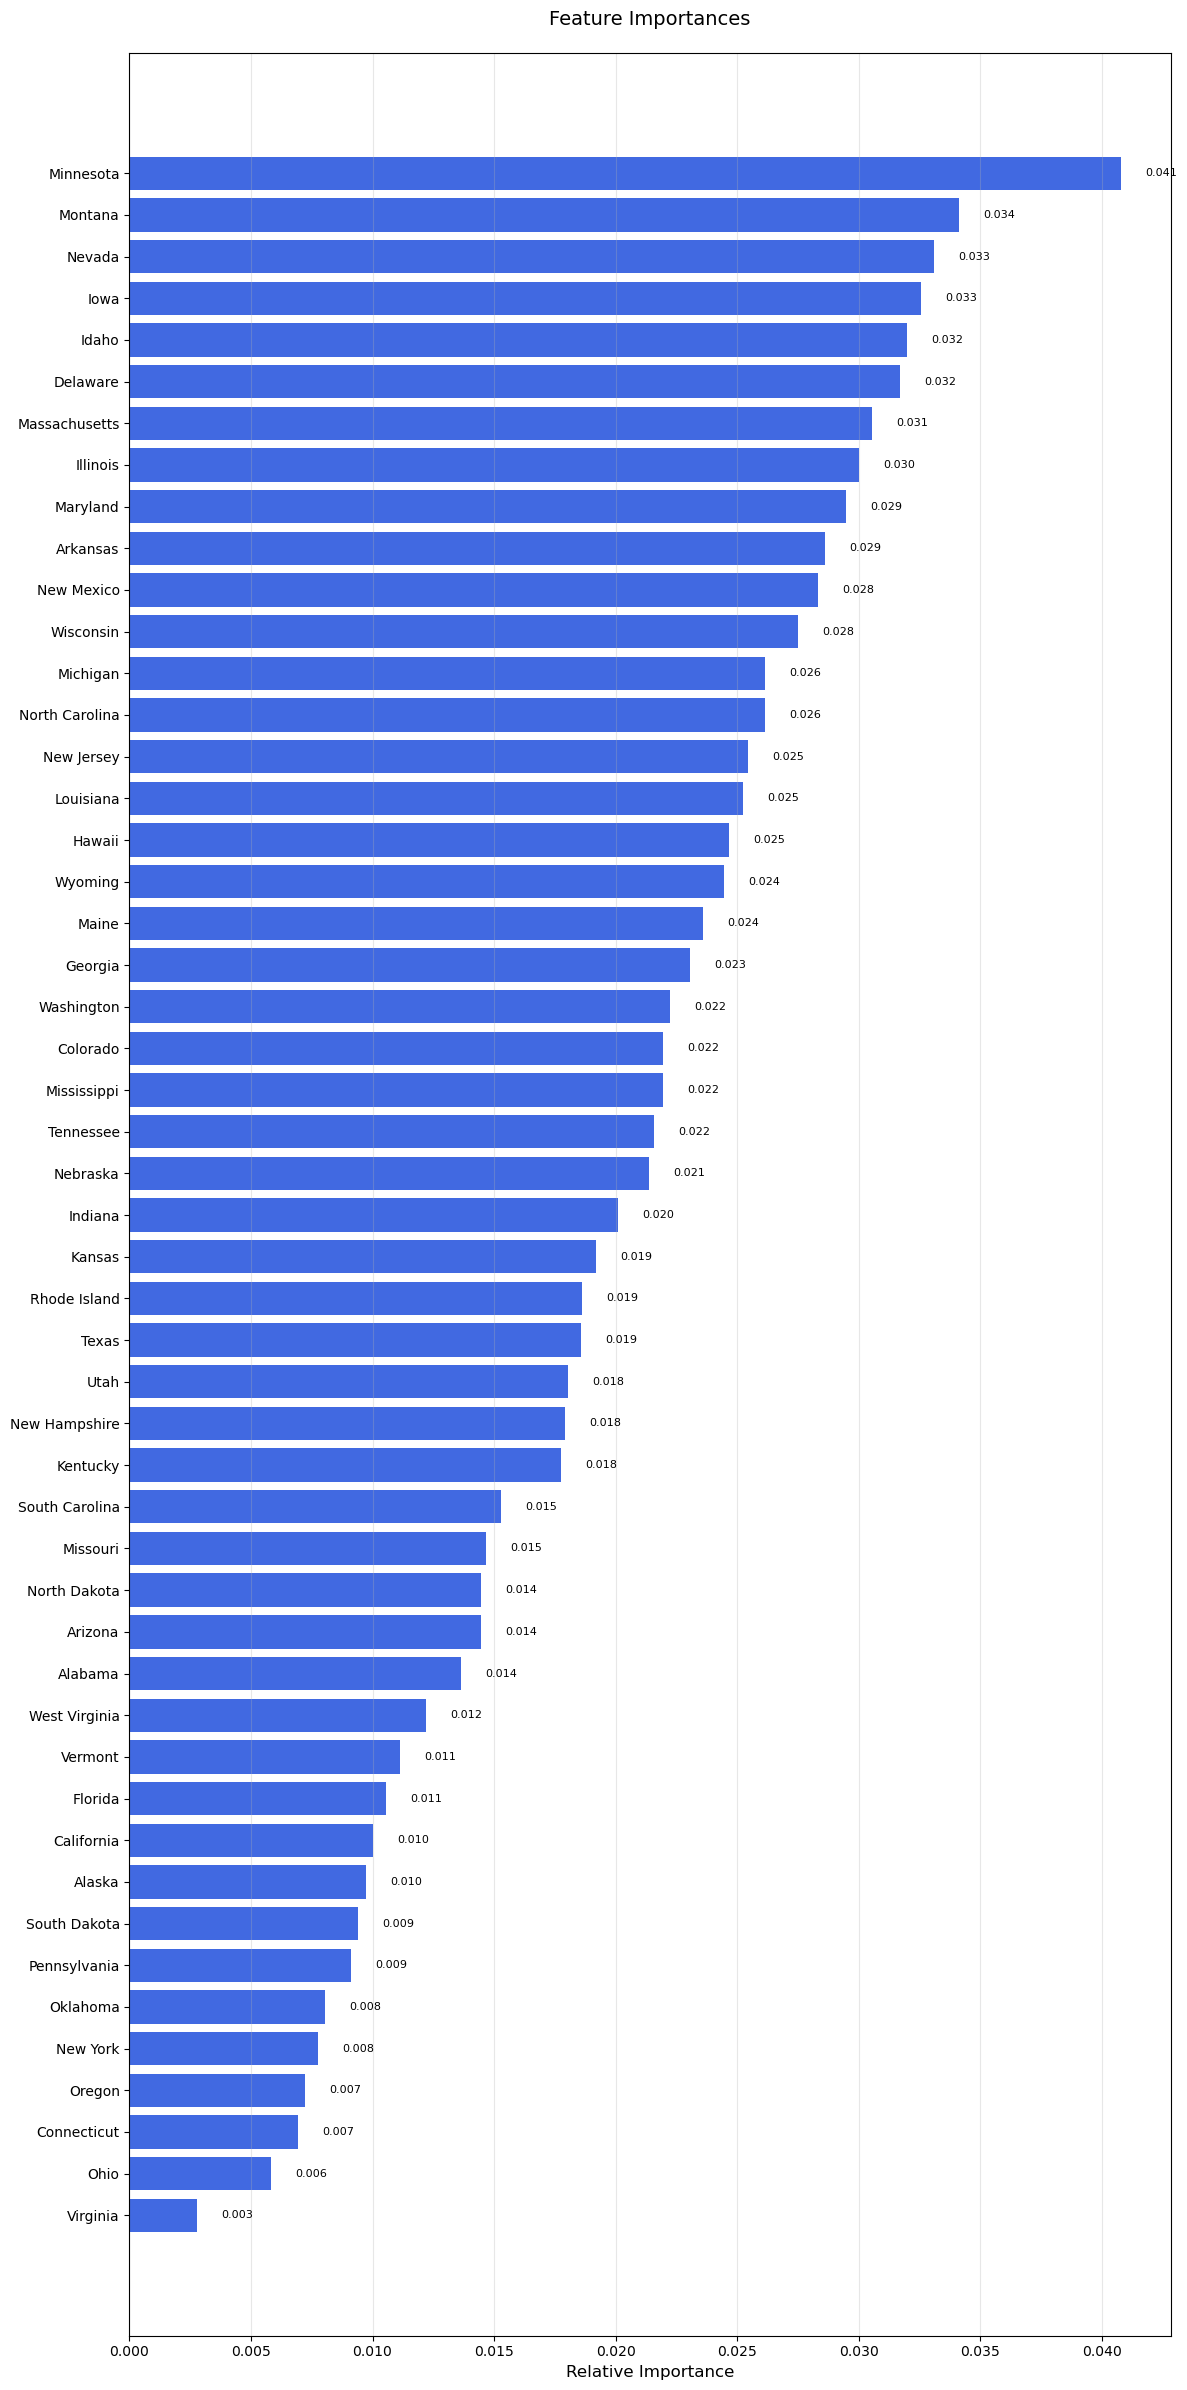

In [21]:
plt.figure(figsize=(12, 24))  # Double the height (from 12 to 24)

# Get feature names and importances
feature_names = X.columns if hasattr(X, 'columns') else X.index
importances = model.feature_importances_
sorted_idx = np.argsort(importances)

# Create plot with adjusted formatting
bars = plt.barh(
    range(len(sorted_idx)),
    importances[sorted_idx],
    color='royalblue',
    height=0.8  # Makes bars thicker for better visibility
)

# Label customization
plt.yticks(
    range(len(sorted_idx)),
    [feature_names[i] for i in sorted_idx],
    fontsize=10  # Increase font size
)
plt.title('Feature Importances', pad=20, fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.grid(axis='x', alpha=0.3)  # Light grid for reference

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.001,  # Small offset from bar end
        bar.get_y() + bar.get_height()/2,
        f'{width:.3f}',
        va='center',
        fontsize=8
    )

plt.tight_layout()
plt.show()

#### With the merged regions dataframe I can determine that Regions 7, 12, 3, and 19 are probably worth removing. 

# Next up for feature selection are my targets, which were overfitted. I'm going to hone in on whatever rank the highest. 

In [3]:
# Looking at the features

le = LabelEncoder()
y = le.fit_transform(features23.index)
X = features23.copy()

features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

#### I'm encoding states as the target variable to see how well these features make the regions distinct.

In [4]:
# Imputing the NAs

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [5]:
# Scaling my features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Not a great score, but gives me a peek into feature importance. 

ridgeReg = Ridge(alpha=.01)
ridgeReg.fit(X_train,y_train)
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)
print(train_score_ridge)
print(test_score_ridge)

0.16525324704641797
-3.538688739208159


In [7]:
coefficients = ridgeReg.coef_
importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(importance)

                                             Feature  Coefficient
3                 Cannot finance improvements (2023)    30.786973
1  Risk of reduced yield or poorer crop quality (...    27.122132
6  Will not be farming this operation long enough...    -5.389996
2  Physical field or crop conditions limit system...    -5.980174
0   Investigating improvements not a priority (2023)   -10.247247
5  Uncertainty about future availability of water...   -19.115924
4             Landlord will not share in cost (2023)   -21.346683


In [9]:
importance.to_csv('ridge_regression.csv', index=False)

#### Now it is clear that Finances and Risk of Reduced Yield are the biggest factors at play.

#### Time to visualize this and then cull the features from the dataframes.

/var/folders/d7/s9v4vr012y797bmw4ryrcfgc0000gn/T/ipykernel_9490/2479383454.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


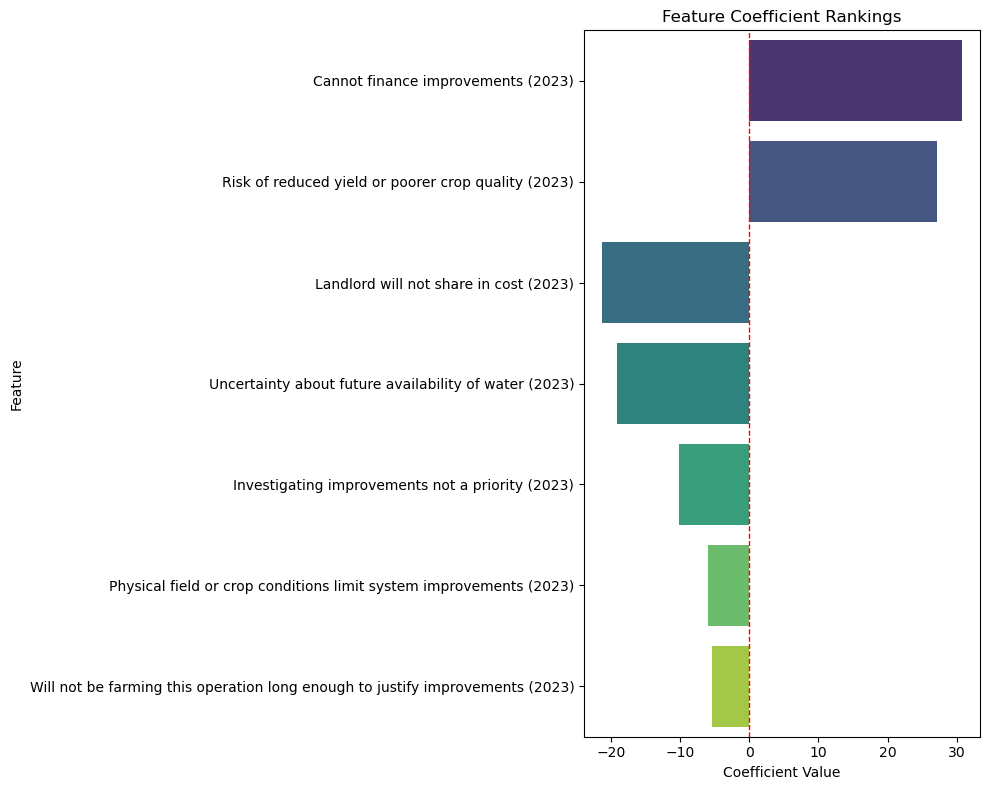

In [8]:
importance['AbsCoefficient'] = importance['Coefficient'].abs()
importance = importance.sort_values(by='AbsCoefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance, 
    x='Coefficient', 
    y='Feature', 
    palette='viridis'
)
plt.title('Feature Coefficient Rankings')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='red', linestyle='--', linewidth=1)  # To show the neutral line
plt.tight_layout()
plt.show()

#### Since my target is categorical, negative coefficients represent noisy/inconsistent data rather than inverse relationships. 

In [28]:
# Getting the negative features and removing them. 

negative_features = importance[importance['Coefficient'] < 0]['Feature'].tolist()

features23 = features23.drop(
    columns=[col for col in negative_features if col in features23.columns]
)

#### Because this worked so well I'm going to do the same for each year's dataframe.

In [29]:
le = LabelEncoder()
y = le.fit_transform(features18.index)
X = features18.copy()
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ridgeReg = Ridge(alpha=.01)
ridgeReg.fit(X_train,y_train)
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

coefficients = ridgeReg.coef_
importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(importance)

                                             Feature  Coefficient
2                 Cannot finance improvements (2018)    34.544345
0  Risk of reduced yield or poorer crop quality (...    -3.765101
5  Will not be farming this operation long enough...    -4.811354
4  Uncertainty about future availability of water...    -4.831011
1  Physical field or crop conditions limit system...    -5.480902
3             Landlord will not share in cost (2018)   -16.933198


In [30]:
negative_features = importance[importance['Coefficient'] < 0]['Feature'].tolist()

features18 = features18.drop(
    columns=[col for col in negative_features if col in features18.columns]
)

In [31]:
le = LabelEncoder()
y = le.fit_transform(features13.index)
X = features13.copy()
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ridgeReg = Ridge(alpha=.01)
ridgeReg.fit(X_train,y_train)
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

coefficients = ridgeReg.coef_
importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(importance)

                                             Feature  Coefficient
0  Risk of reduced yield or poorer crop quality (...    36.988975
1  Physical field or crop conditions limit system...    28.794685
2                 Cannot finance improvements (2013)    16.330781
3             Landlord will not share in cost (2013)   -25.803197
4  Uncertainty about future availability of water...   -27.765354
5  Will not be farming this operation long enough...   -29.344550


In [32]:
negative_features = importance[importance['Coefficient'] < 0]['Feature'].tolist()

features13 = features13.drop(
    columns=[col for col in negative_features if col in features13.columns]
)

In [33]:
le = LabelEncoder()
y = le.fit_transform(features03.index)
X = features03.copy()
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ridgeReg = Ridge(alpha=.01)
ridgeReg.fit(X_train,y_train)
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

coefficients = ridgeReg.coef_
importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(importance)

                                             Feature  Coefficient
5  Will not be farming this operation long enough...    17.518265
2                 Cannot finance improvements (2003)    11.150925
1  Physical field or crop conditions limit system...     3.783344
0  Risk of reduced yield or poorer crop quality (...     1.148883
4  Uncertainty about future availability of water...    -9.995019
3             Landlord will not share in cost (2003)   -23.649906


In [34]:
negative_features = importance[importance['Coefficient'] < 0]['Feature'].tolist()

features03 = features03.drop(
    columns=[col for col in negative_features if col in features03.columns]
)

In [84]:
le = LabelEncoder()
y = le.fit_transform(features_all.index)
X = features_all.copy()
features = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ridgeReg = Ridge(alpha=.01)
ridgeReg.fit(X_train,y_train)
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

coefficients = ridgeReg.coef_
importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(importance)

                                              Feature  Coefficient
23                 Cannot finance improvements (2003)    74.889844
17                 Cannot finance improvements (2013)    70.611255
19  Uncertainty about future availability of water...    70.256037
15  Risk of reduced yield or poorer crop quality (...    46.676558
1   Risk of reduced yield or poorer crop quality (...    41.429838
14   Investigating improvements not a priority (2013)    31.546494
26  Will not be farming this operation long enough...    28.107901
22  Physical field or crop conditions limit system...    17.271807
10                 Cannot finance improvements (2018)    15.626637
11             Landlord will not share in cost (2018)    14.018277
8   Risk of reduced yield or poorer crop quality (...    13.182394
7    Investigating improvements not a priority (2018)     8.251849
21  Risk of reduced yield or poorer crop quality (...     7.115603
2   Physical field or crop conditions limit system...     6.45

In [85]:
negative_features = importance[importance['Coefficient'] < 0]['Feature'].tolist()

features_all = features_all.drop(
    columns=[col for col in negative_features if col in features03.columns]
)

In [72]:
important_features = features23.join([features18, features13, features03], how='outer')
important_features.to_csv('features_merged.csv', index=True)

important_features = pd.read_csv(path + 'important_features.csv')
important_features = important_features.set_index('AREA')